In [ ]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import pylab as plt

# add ../mcjax to the path
import sys
sys.path.append('../../')

from mcjax.proba.gaussian import IsotropicGauss
from mcjax.mcmc.mala import Mala



In [2]:
# initialize jax RNG
key = jr.key(0)

In [3]:
def Sample_Mala(sampler, n_steps, key,initial):
    state_init = sampler.init_state(initial)
    mcmc_output = sampler.run(key = key, n_samples=n_steps, state_init=state_init)
    summary = mcmc_output.summary
    return summary.acceptance_rate

In [4]:
dim_arr = jnp.arange(1,101,10)
acc_rate_arr1 = []
acc_rate_arr2 = []
acc_rate_arr3 = []
acc_rate = {"acc_rate_arr"+str(i):[] for i in range(1,5)}
for dim in dim_arr:
    print(f"Running for dim = {dim}")
    # Target distribution
    mu = jnp.full(dim,1.)
    log_var = jnp.log(2)
    dist = IsotropicGauss(mu=mu,log_var=log_var)
    logdensity = dist.logdensity
    # random walk metropolis
    mcmc1 = Mala(logdensity=logdensity,step_size=1)
    mcmc2 = Mala(logdensity=logdensity,step_size=1/dim**(1/3))
    mcmc3 = Mala(logdensity=logdensity,step_size=1/dim**(1/2))
    mcmc4 = Mala(logdensity=logdensity,step_size=1/dim)
    mcmc_list = [mcmc1,mcmc2,mcmc3,mcmc4]
    
    # sample the trajectory with step size o(1/d)
    key, key_ = jr.split(key)
    x0 = jnp.zeros((dim,))
    n_steps = 100_000
    for i in range(1,5):
        acc_rate["acc_rate_arr"+str(i)].append(Sample_Mala(mcmc_list[i-1],n_steps,key,x0))



Running for dim = 1
Running for dim = 11
Running for dim = 21
Running for dim = 31
Running for dim = 41
Running for dim = 51
Running for dim = 61
Running for dim = 71
Running for dim = 81
Running for dim = 91


Text(0.5, 1.0, 'Acceptance rate for different scaling schema of step size')

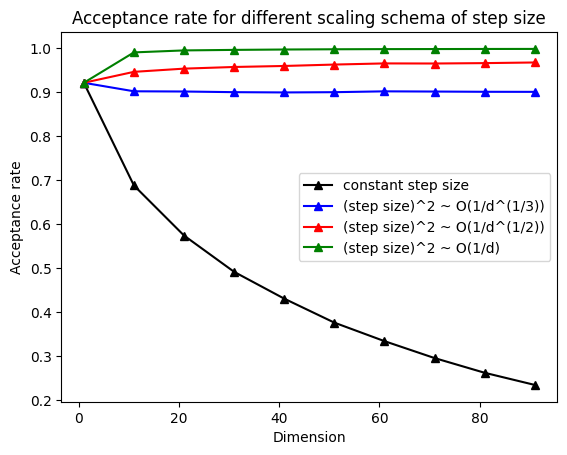

In [6]:
plt.plot(dim_arr,acc_rate["acc_rate_arr1"], "k-^",label="constant step size")
plt.plot(dim_arr,acc_rate["acc_rate_arr2"], "b-^",label="(step size)^2 ~ O(1/d^(1/3))")
plt.plot(dim_arr,acc_rate["acc_rate_arr3"], "r-^",label="(step size)^2 ~ O(1/d^(1/2))")
plt.plot(dim_arr,acc_rate["acc_rate_arr4"], "g-^",label="(step size)^2 ~ O(1/d)")
plt.legend()
plt.xlabel("Dimension")
plt.ylabel("Acceptance rate")
plt.title("Acceptance rate for different scaling schema of step size")


In [7]:
# Efficiency and Acceptance rate
# Set a higher dimension (dim = 20)
dim = 20
# Target distribution
mu = jnp.full(dim,1.)
log_var = jnp.log(2)
dist = IsotropicGauss(mu=mu,log_var=log_var)
density = dist.logdensity

In [8]:
def sample_Mala(key, x0, step_size, n_steps, dim):
    mcmc = Mala(logdensity=density, step_size=step_size**2/dim**(1/3))
    state_init = mcmc.init_state(x0)
    mcmc_output = mcmc.run(key = key, n_samples=n_steps, state_init=state_init)
    return mcmc_output

sample_Mala = jax.jit(sample_Mala, static_argnums=(3,4))
sample_Mala_batch = jax.vmap(sample_Mala, in_axes=(0, None, 0, None, None))
sample_Mala_batch = jax.jit(sample_Mala_batch, static_argnums=(3,4))


In [9]:
step_size_arr = np.linspace(0.01, 5., 200)
n_steps = 200_000
keys = jax.random.split(jax.random.PRNGKey(0), len(step_size_arr) + 1)
keys, key_ = keys[:-1], keys[-1]
x0 = jnp.zeros((dim,))
mcmc_output_batch = sample_Mala_batch(keys, x0, step_size_arr, n_steps,dim)
traj_batch = mcmc_output_batch.traj
summary_batch = mcmc_output_batch.summary

Text(0.5, 1.0, 'Efficiency v.s. Acc rate')

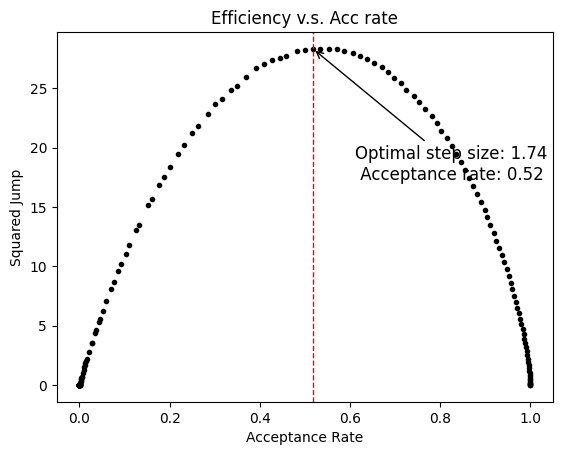

In [10]:
efficiency = [summary_batch.sq_jump[i] for i in range(len(step_size_arr))]
plt.plot(summary_batch.acceptance_rate, efficiency, ".", color='black')

# find the optimal step size by maximizing the squared jump
index_opt = np.argmax(efficiency)
optimal_step_size = step_size_arr[index_opt]
optimal_acceptance_rate = summary_batch.acceptance_rate[index_opt]

# draw vertical line at the optimal step size
plt.axvline(optimal_acceptance_rate, color='red', lw=1, ls='--')
# add an arrow pointing to the optimal step size with the value
plt.annotate(f"Optimal step size: {optimal_step_size:.2f} \n Acceptance rate: {optimal_acceptance_rate:.2f}",
                xy=(optimal_acceptance_rate, efficiency[index_opt]),
                xytext=(0.6, 0.6),
                textcoords='axes fraction',
                arrowprops=dict(facecolor='red', arrowstyle="->"),
                fontsize=12)
plt.xlabel("Acceptance Rate")
plt.ylabel("Squared Jump")
plt.title("Efficiency v.s. Acc rate")